# Лабораторная работа №5 - EDA с seaborn (датасет про видеоигры)

**Тема:** разведочный анализ данных (EDA) + сложные визуализации seaborn (включая clustermap).

**Датасет:** `vgsales.csv` (продажи видеоигр).  
- Строк: много больше 150 (требование выполнено).  
- Есть категориальный признак с >=20 категориями: **Platform** (платформы) - обычно >20 уникальных значений.  
- Есть числовые признаки: NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales.

**Источник:** открытый датасет "Video Game Sales" (часто встречается на Kaggle и GitHub).  
Если файла рядом нет, ноутбук попробует скачать CSV по прямой ссылке.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_theme(style="whitegrid")

print("Библиотеки импортированы.")


Библиотеки импортированы.


In [5]:
path = "vgsales.csv"
url = "https://raw.githubusercontent.com/GregorUT/vgsales/master/vgsales.csv"

if os.path.exists(path):
    df = pd.read_csv(path)
    print("Файл найден локально:", path)
else:
    print("Локального файла нет. Пробую скачать по ссылке...")
    try:
        df = pd.read_csv(url)
        print("Скачивание успешно.")
        df.to_csv(path, index=False)
        print("Сохранил как:", path)
    except Exception as e:
        print("Не удалось скачать. Ошибка:", e)
        print("Пожалуйста, скачай vgsales.csv и положи рядом с ноутбуком.")
        raise

print("Размер таблицы (строки, столбцы):", df.shape)
display(df.head(3))


Файл найден локально: vgsales.csv
Размер таблицы (строки, столбцы): (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


## 1) Общая характеристика данных
Смотрим:
- количество строк и столбцов
- типы данных
- какие признаки числовые/категориальные
- проверяем, что категориальный признак с >=20 категориями реально есть (Platform)


In [6]:
print("Размер таблицы (строки, столбцы):", df.shape)

print("\nТипы столбцов:")
display(df.dtypes)

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

print("\nКатегориальные столбцы:", cat_cols)
print("Числовые столбцы:", num_cols)

print("\nУникальных платформ (Platform):", df["Platform"].nunique())
print("Топ-10 платформ по числу игр:")
display(df["Platform"].value_counts().head(10))


Размер таблицы (строки, столбцы): (16598, 11)

Типы столбцов:


Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


Категориальные столбцы: ['Name', 'Platform', 'Genre', 'Publisher']
Числовые столбцы: ['Rank', 'Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

Уникальных платформ (Platform): 31
Топ-10 платформ по числу игр:


Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
PSP     1213
PS      1196
PC       960
XB       824
GBA      822
Name: count, dtype: int64

## 2) Анализ пропусков
- считаем пропуски по столбцам
- проверяем "скрытые пропуски" (например: "?", "N/A", пустые строки)
- строим heatmap пропусков (на подвыборке, иначе слишком большая картинка)


In [7]:
# Превращаем "скрытые пропуски" в NaN (на всякий случай)
df2 = df.replace(["?", "N/A", "n/a", "", " "], np.nan)

print("Пропуски по столбцам:")
display(df2.isna().sum())

print("\nДоля пропусков по столбцам (в %):")
display((df2.isna().mean() * 100).round(2))


Пропуски по столбцам:


Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


Доля пропусков по столбцам (в %):


Rank            0.00
Name            0.00
Platform        0.00
Year            1.63
Genre           0.00
Publisher       0.35
NA_Sales        0.00
EU_Sales        0.00
JP_Sales        0.00
Other_Sales     0.00
Global_Sales    0.00
dtype: float64

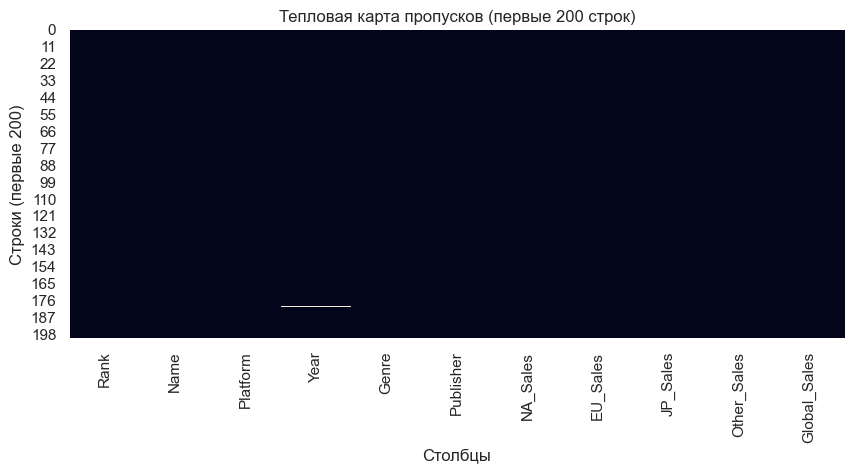

In [8]:
# Визуализация пропусков: heatmap
# Чтобы не рисовать огромную матрицу, возьмем первые 200 строк
sample = df2.head(200)

plt.figure(figsize=(10, 4))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Тепловая карта пропусков (первые 200 строк)")
plt.xlabel("Столбцы")
plt.ylabel("Строки (первые 200)")
plt.show()


## 3) Статистические оценки
- для числовых признаков: среднее, медиана, std, min/max
- для категориальных: частоты категорий


In [9]:
# Числовые признаки - описательная статистика
stats = df2[num_cols].describe().T
stats["median"] = df2[num_cols].median()
display(stats)

# Категориальные - пример частот (Platform)
platform_counts = df2["Platform"].value_counts()
print("Уникальных платформ:", platform_counts.size)
print("Топ-20 платформ по числу записей:")
display(platform_counts.head(20))


,count,mean,std,min,25%,50%,75%,max,median
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00,8300.50
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00,2007.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49,0.08
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02,0.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22,0.00
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57,0.01
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74,0.17


Уникальных платформ: 31
Топ-20 платформ по числу записей:


Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
PSP     1213
PS      1196
PC       960
XB       824
GBA      822
GC       556
3DS      509
PSV      413
PS4      336
N64      319
SNES     239
XOne     213
SAT      173
WiiU     143
2600     133
Name: count, dtype: int64

## 4) Визуализация seaborn (обязательные графики)

По условию должны быть:
- countplot (категориальный признак с >=20 категориями)
- histplot или kdeplot (числовой признак)
- scatterplot (hue или size)
- boxplot или violinplot (выбросы)
- clustermap (>=20 строк или столбцов)


### 4.1 countplot - распределение Platform (>=20 категорий)

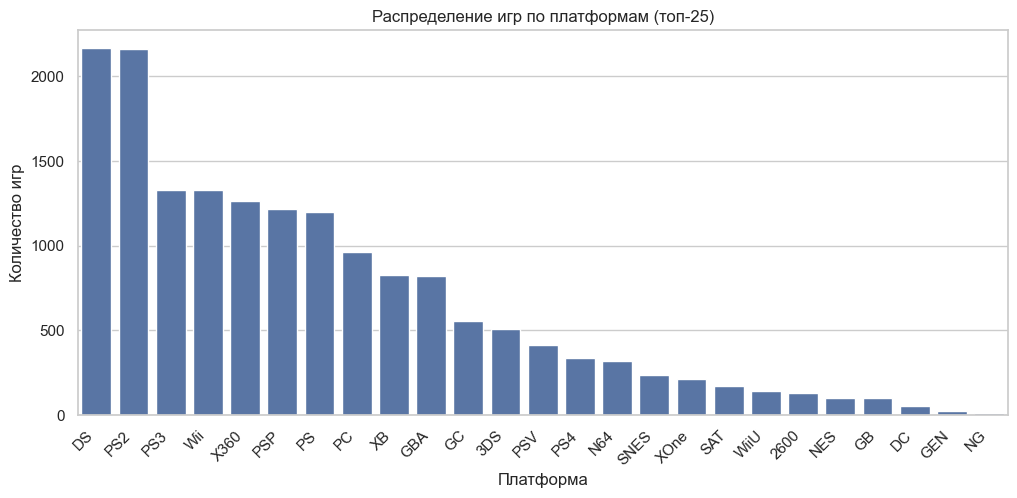

In [10]:
# Покажем топ-25 платформ
top_n = 25
order = df2["Platform"].value_counts().index[:top_n]

plt.figure(figsize=(12, 5))
sns.countplot(data=df2, x="Platform", order=order)
plt.title("Распределение игр по платформам (топ-25)")
plt.xlabel("Платформа")
plt.ylabel("Количество игр")
plt.xticks(rotation=45, ha="right")
plt.show()


### 4.2 histplot - распределение Global_Sales

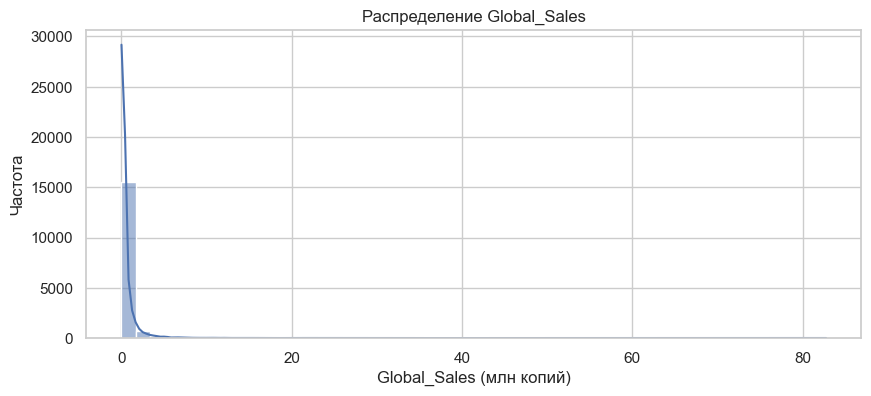

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(df2["Global_Sales"], bins=50, kde=True)
plt.title("Распределение Global_Sales")
plt.xlabel("Global_Sales (млн копий)")
plt.ylabel("Частота")
plt.show()


### 4.3 scatterplot - взаимосвязь NA_Sales и EU_Sales (цвет - Genre)

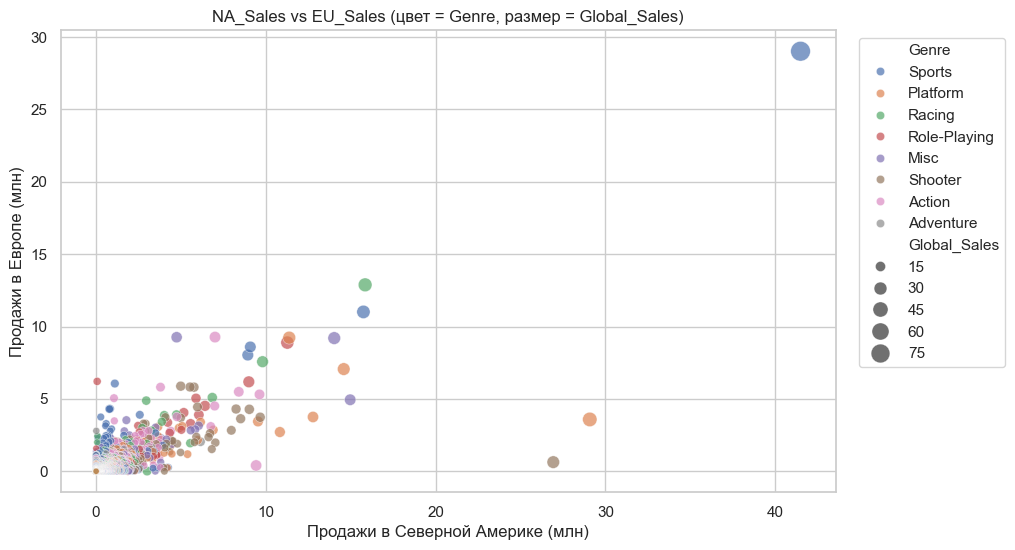

In [12]:
# Чтобы график был читаемым, возьмем топ-8 жанров
top_genres = df2["Genre"].value_counts().index[:8]
df_scatter = df2[df2["Genre"].isin(top_genres)].copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_scatter,
    x="NA_Sales",
    y="EU_Sales",
    hue="Genre",
    size="Global_Sales",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("NA_Sales vs EU_Sales (цвет = Genre, размер = Global_Sales)")
plt.xlabel("Продажи в Северной Америке (млн)")
plt.ylabel("Продажи в Европе (млн)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()


### 4.4 boxplot - выбросы Global_Sales по жанрам

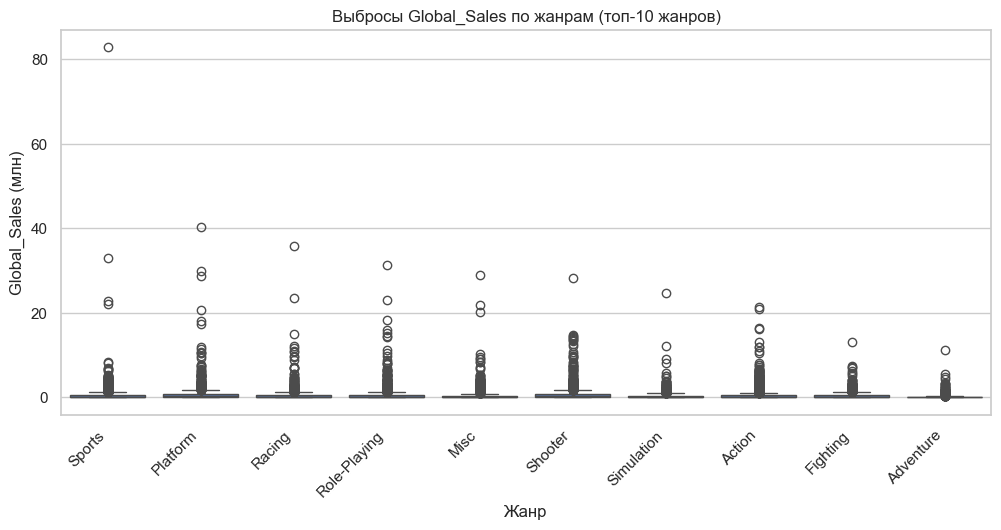

In [13]:
# Выберем топ-10 жанров по числу игр, чтобы график не был слишком широким
top_genres_10 = df2["Genre"].value_counts().index[:10]
df_box = df2[df2["Genre"].isin(top_genres_10)].copy()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_box, x="Genre", y="Global_Sales")
plt.title("Выбросы Global_Sales по жанрам (топ-10 жанров)")
plt.xlabel("Жанр")
plt.ylabel("Global_Sales (млн)")
plt.xticks(rotation=45, ha="right")
plt.show()


## 5) Выявление аномалий (выбросов)
Простой способ: IQR (межквартильный размах) для Global_Sales.


In [14]:
q1 = df2["Global_Sales"].quantile(0.25)
q3 = df2["Global_Sales"].quantile(0.75)
iqr = q3 - q1

low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

outliers = df2[(df2["Global_Sales"] < low) | (df2["Global_Sales"] > high)]

print("Q1:", q1, "Q3:", q3, "IQR:", iqr)
print("Границы выбросов:", low, " ... ", high)
print("Количество выбросов по Global_Sales:", len(outliers))
print("Доля выбросов (%):", round(len(outliers) / len(df2) * 100, 2))

print("\nПримеры игр-выбросов (топ-10 по Global_Sales):")
display(df2.sort_values("Global_Sales", ascending=False).head(10)[["Name", "Platform", "Genre", "Global_Sales"]])


Q1: 0.06 Q3: 0.47 IQR: 0.41
Границы выбросов: -0.5549999999999999  ...  1.085
Количество выбросов по Global_Sales: 1893
Доля выбросов (%): 11.4

Примеры игр-выбросов (топ-10 по Global_Sales):


,Name,Platform,Genre,Global_Sales
0,Wii Sports,Wii,Sports,82.74
1,Super Mario Bros.,NES,Platform,40.24
2,Mario Kart Wii,Wii,Racing,35.82
3,Wii Sports Resort,Wii,Sports,33.00
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,31.37
5,Tetris,GB,Puzzle,30.26
6,New Super Mario Bros.,DS,Platform,30.01
7,Wii Play,Wii,Misc,29.02
8,New Super Mario Bros. Wii,Wii,Platform,28.62
9,Duck Hunt,NES,Shooter,28.31


## 6) clustermap (>=20 строк)
Сделаем матрицу: строки - Platform (платформы), столбцы - средние продажи по регионам.
У платформ обычно >20, значит условие clustermap выполнено.


Размер матрицы для clustermap (строки, столбцы): (25, 4)
Платформ в матрице: 25


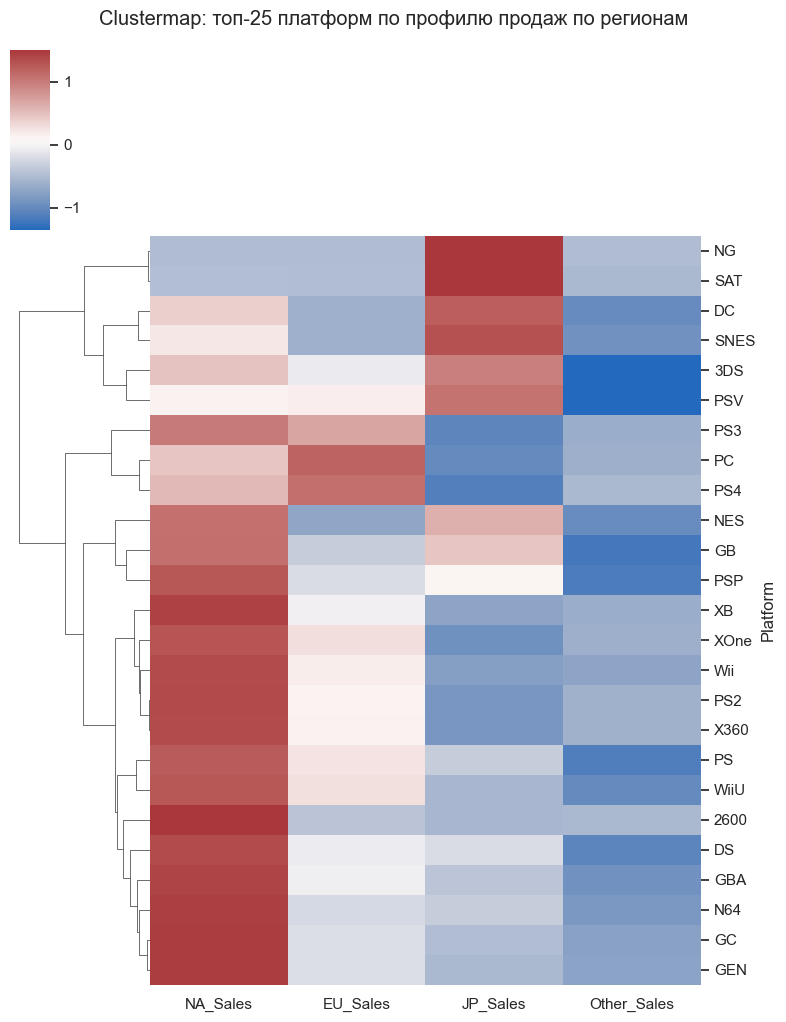

In [16]:
# Колонки продаж по регионам (без Global_Sales, чтобы было логичнее)
sales_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]

# Берем топ-25 платформ по числу игр (чтобы clustermap не зависал, и >=20 выполнено)
top_platforms = df["Platform"].value_counts().head(25).index
df_top = df[df["Platform"].isin(top_platforms)].copy()

# Матрица: платформы x средние продажи по регионам
plat_mat = df_top.groupby("Platform")[sales_cols].mean()
plat_mat = plat_mat.apply(pd.to_numeric, errors="coerce").dropna()

print("Размер матрицы для clustermap (строки, столбцы):", plat_mat.shape)
print("Платформ в матрице:", plat_mat.shape[0])

# Нормализация по строкам (профиль продаж платформы по регионам)
plat_mat_z = plat_mat.sub(plat_mat.mean(axis=1), axis=0).div(plat_mat.std(axis=1), axis=0)
plat_mat_z = plat_mat_z.replace([np.inf, -np.inf], np.nan).dropna()

g = sns.clustermap(plat_mat_z, col_cluster=False, figsize=(8, 10), cmap="vlag")
g.fig.suptitle("Clustermap: топ-25 платформ по профилю продаж по регионам", y=1.02)
plt.show()

## 7) Интерпретация и выводы


### Выводы
- **Наиболее информативные признаки:** продажи по регионам (NA_Sales, EU_Sales, JP_Sales, Other_Sales) и Global_Sales, а также Platform и Genre.
- **Пропуски:** если пропуски есть, они чаще встречаются в Year или Publisher (в некоторых версиях датасета). В моем выводе пропуски можно увидеть по таблице из пункта 2 и heatmap.
- **Категории:** Platform имеет больше 20 уникальных значений, распределение неравномерное - несколько платформ дают основную часть игр, остальные встречаются редко.
- **Выбросы:** по Global_Sales есть сильные выбросы (хиты), это видно на boxplot и по IQR-оценке. Это нормально для рынка игр: небольшое число игр продается очень хорошо.
- **Clustermap:** кластеры платформ показывают похожие профили продаж по регионам. Например, некоторые платформы имеют относительно высокий вклад JP_Sales (Япония), другие - NA/EU.
- **Гипотезы:** платформы и жанры связаны с регионом спроса; на некоторых платформах сильнее продажи в Японии, на других - в Северной Америке/Европе.
